### Goals - Classify the detailed user intent from short text snippets with Spark NLP (JSL)
1. **Intent classification** using a Spark NLP pretrained model
2. **Create & train** a new Spark NLP ClassifierDL model
3. **NER** ... going beyond the initial benchmark of 8 classes, into flight.from, flight.to, flight.date, meal_desc, airport.name and etc. with a different Spark NLP pretrained model

Data from ATIS - Airline Travel Info System https://www.kaggle.com/hassanamin/atis-airlinetravelinformationsystem

### Spark NLP Refs:
- **Home repository:** https://github.com/JohnSnowLabs/spark-nlp
- **Full list of pretrained models/pipelines:** https://github.com/JohnSnowLabs/spark-nlp-models
- **All examples:** https://github.com/JohnSnowLabs/spark-nlp-workshop

# Install Spark NLP and dependencies

In [ ]:
%%time

import numpy as np  
import pandas as pd  
from tqdm.auto import tqdm
tqdm.pandas()

import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark==2.4.7 spark-nlp==2.7.5

#!ls '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ['PATH'] = os.environ['JAVA_HOME'] + "/bin:" + os.environ['PATH']

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

import sparknlp
from sparknlp.annotator import *
from sparknlp.base import *
spark = sparknlp.start()

from sklearn.metrics import classification_report

print("Apache Spark version", spark.version)
print("Spark NLP version", sparknlp.version())

# Data

In [ ]:
train = pd.read_csv('../input/atis-airlinetravelinformationsystem/atis_intents_train.csv')
train.columns = ['intent', 'snippet']

print(train.shape)
train.head()

In [ ]:
train.intent.value_counts(), train.intent.value_counts(normalize=True)

In [ ]:
test = pd.read_csv('../input/atis-airlinetravelinformationsystem/atis_intents_test.csv')
test.columns = ['intent', 'snippet']

print(test.shape)
test.head()

In [ ]:
test.intent.value_counts(), test.intent.value_counts(normalize=True)

# 1. Intent classification with a Spark NLP pretrained model

### Download the pretrained Pipeline
https://nlp.johnsnowlabs.com/2021/01/25/classifierdl_use_atis_en.html


In [ ]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained('tfhub_use', lang="en") \
    .setInputCols(["document"])\
    .setOutputCol("sentence_embeddings")

document_classifier = ClassifierDLModel.pretrained('classifierdl_use_atis', 'en') \
  .setInputCols(["document", "sentence_embeddings"]) \
  .setOutputCol("class")

nlpPipeline = Pipeline(stages=[document_assembler, use, document_classifier])
light_pipeline = LightPipeline(nlpPipeline.fit(spark.createDataFrame([['']]).toDF("text")))

In [ ]:
example = ['I want to fly from Albany NY to Tampa Florida.', 'what would be the cost of the flight ']
result = light_pipeline.annotate(example)
result

### Performance on test

In [ ]:
example = test.snippet.tolist()
result = light_pipeline.annotate(example)
Preds = []
for j in range(len(result)):
    Preds.append(result[j]['class'][0])
    
Truth = test.intent.tolist()

print(classification_report(Truth, Preds))

### NOTE the classifierdl_use_atis model was trained on 5 classes and not 8
https://nlp.johnsnowlabs.com/2021/01/25/classifierdl_use_atis_en.html ... so we remove the classes Spark has not seen during pretraining

In [ ]:
test = test[(test['intent'] != 'atis_aircraft') &
                   (test['intent'] != 'atis_flight_time') &
                   (test['intent'] != 'atis_quantity')  ] 
test.shape

In [ ]:
example = test.snippet.tolist()
result = light_pipeline.annotate(example)
Preds = []
for j in range(len(result)):
    Preds.append(result[j]['class'][0])
    
Truth = test.intent.tolist()

print(classification_report(Truth, Preds))

# 2. Create & train a new Spark NLP ClassifierDL model

Based on https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/5.Text_Classification_with_ClassifierDL.ipynb

In [ ]:
trainDataset = spark.createDataFrame(train)
trainDataset.show(truncate=50)

In [ ]:
from pyspark.sql.functions import col

print(trainDataset.count())

trainDataset.groupBy("intent") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

In [ ]:
testDataset = spark.createDataFrame(test)
testDataset.show(truncate=50)

In [ ]:
from pyspark.sql.functions import col

print(testDataset.count())

testDataset.groupBy("intent") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("snippet") \
    .setOutputCol("document")
    
tokenizer = Tokenizer() \
  .setInputCols(["document"]) \
  .setOutputCol("token")
    
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)

lemma = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma")

In [ ]:
glove_embeddings = WordEmbeddingsModel().pretrained() \
 .setInputCols(["document",'lemma'])\
 .setOutputCol("embeddings")\
 .setCaseSensitive(False)

embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["document", "embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE")

classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("intent")\
  .setMaxEpochs(3)\
  .setEnableOutputLogs(True)
  #.setOutputLogsPath('logs')

clf_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            lemma, 
            glove_embeddings,
            embeddingsSentence,
            classsifierdl])

### default classifierDL params:

maxEpochs -> 10,
lr -> 5e-3f,
dropout -> 0.5f,
batchSize -> 64,
enableOutputLogs -> false,
verbose -> Verbose.Silent.id,
validationSplit -> 0.0f,
outputLogsPath -> ""


### Train

In [ ]:
%%time

# Train gpu = 14 secs... no gpu 16 secs
#spark = sparknlp.start(gpu = True)

clf_pipelineModel = clf_pipeline.fit(trainDataset)

### Test

In [ ]:
test = pd.read_csv('../input/atis-airlinetravelinformationsystem/atis_intents_test.csv')
test.columns = ['intent', 'snippet']

print(test.shape)
test.head()

In [ ]:
testDataset = spark.createDataFrame(test)
testDataset.show(10)

In [ ]:
# get the predictions on test Set

preds = clf_pipelineModel.transform(testDataset)
preds_df = preds.select("intent","class.result").toPandas()
for j in range(preds_df.shape[0]):
    preds_df.result[j] = preds_df.result[j][0]
preds_df.sample(10)

In [ ]:

# Definitely WORSE than the pretrained model above...this one always predicts the majority class 

print(classification_report(preds_df.intent, preds_df.result))

# 3. NER ... going beyond the initial benchmark of 8 classes

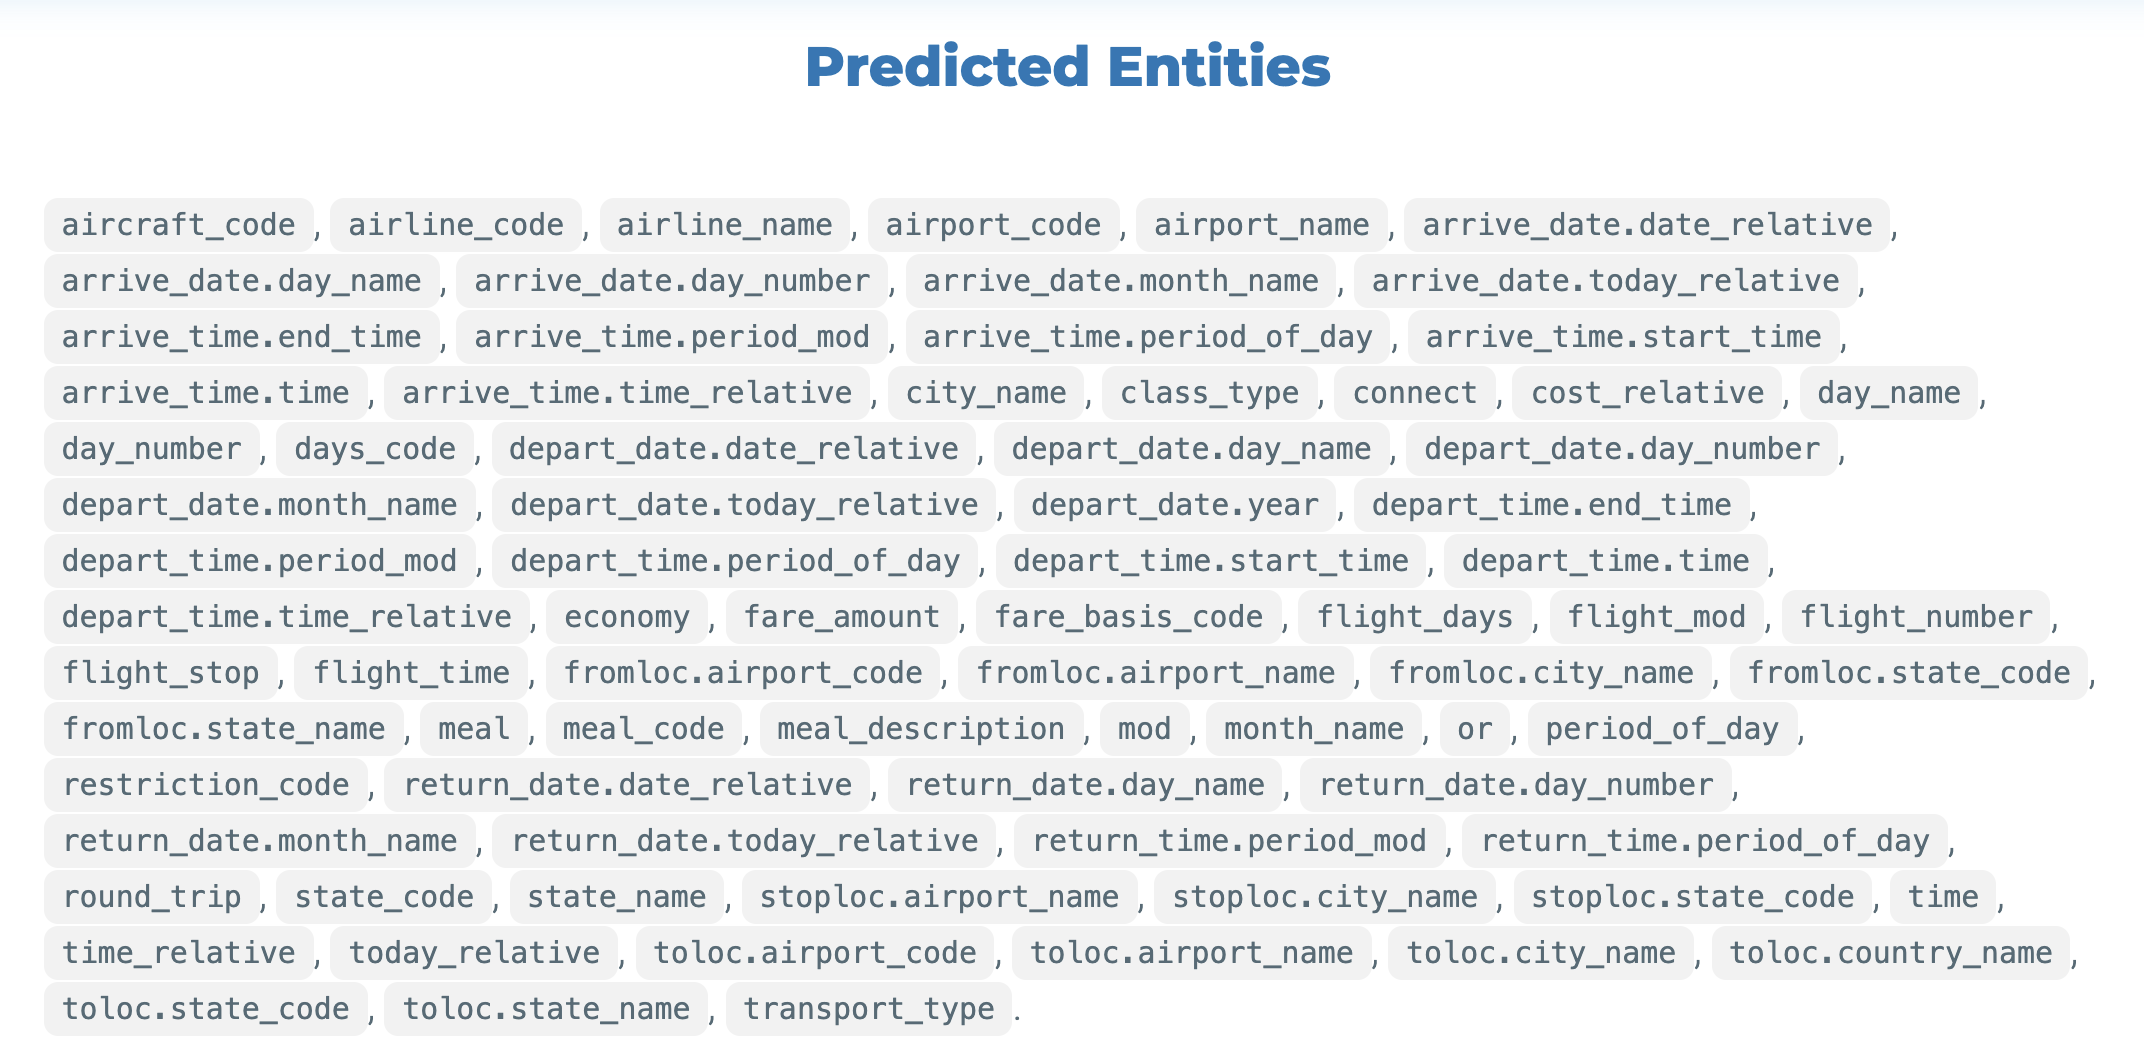

Based on https://nlp.johnsnowlabs.com/2021/01/25/nerdl_atis_840b_300d_en.html

In [ ]:
%%time

document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
  .setInputCols(["document"]) \
  .setOutputCol("token")

embeddings = WordEmbeddingsModel.pretrained("glove_840B_300", "xx")\
          .setInputCols("document", "token") \
          .setOutputCol("embeddings")

ner = NerDLModel.pretrained("nerdl_atis_840b_300d", "en") \
        .setInputCols(["document", "token", "embeddings"]) \
        .setOutputCol("ner")

ner_converter = NerConverter()\
    .setInputCols(['document', 'token', 'ner']) \
    .setOutputCol('ner_chunk')

pipeline = Pipeline(stages=[document_assembler, tokenizer, embeddings, ner, ner_converter])


In [ ]:
example = spark.createDataFrame(pd.DataFrame({'text': [
    "How much would cost a trip from Albany to Miami for tomorrow"
    ]}))
result = pipeline.fit(example).transform(example)

result

In [ ]:
# Visualize outputs as data frame ... NOTE pyspark df not pandas df...

exploded = F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata'))
select_expression_0 = F.expr("cols['0']").alias("chunk")
select_expression_1 = F.expr("cols['1']['entity']").alias("ner_label")
result.select(exploded.alias("cols")) \
    .select(select_expression_0, select_expression_1).show(truncate=False)

In [ ]:
resultDF = result.toPandas()
resultDF

In [ ]:
IOIdf = pd.DataFrame(columns = ['Result', 'Entity', 'StrBegin', 'StrEnd'])


for i in range(len(resultDF['ner_chunk'][0])):
    #ResultEntity = [result['ner_chunk'][0][i]['result'] , result['ner_chunk'][0][i]['metadata']['entity']]
    ResultEntity = pd.DataFrame()
    ResultEntity['Result'] = [resultDF['ner_chunk'][0][i]['result']]
    ResultEntity['Entity'] = [resultDF['ner_chunk'][0][i]['metadata']['entity']]
    ResultEntity['StrBegin'] = [resultDF['ner_chunk'][0][i]['begin']]
    ResultEntity['StrEnd'] = [resultDF['ner_chunk'][0][i]['end']]
    #print(ResultEntity)
    
    IOIdf = IOIdf.append(ResultEntity)
    
IOIdf 


In [ ]:
result

Check out my other nb w Spark NLP for Healthcare https://www.kaggle.com/drscarlat/extract-medical-terms-from-free-text-spark-nlp/notebook